In [39]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from src import Spotify

spotify = Spotify()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import pandas as pd
import numpy as np
import random as ran
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as euc

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 수집

In [42]:
spotify.search_tracks
spotify.get_genres
spotify.genres
spotify.get_features()

spotify.get_reco_tracks
spotify.get_features(target="reco")

계속하시려면 next, 종료는 exit를 입력해주세요.exit


# 데이터 전처리

## 데이터 병합

In [50]:
my_features = spotify.features
reco_features = spotify.reco_features
merge_features = pd.concat([my_features, reco_features])

merge_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2y4hHM6c48Qzk0bqh33XfB,0.539,0.237,0,-8.452,0.0273,0.820,0.000000,0.345,0.259,68.045
1,1OQ3PoRZRtE7RH0NIh3p1O,0.359,0.469,7,-8.060,0.0326,0.745,0.000000,0.101,0.259,84.366
0,1cayXr914ctuYeJkv3CPUR,0.677,0.376,0,-9.033,0.0350,0.941,0.000009,0.177,0.318,83.001
1,1e5qALs3pDrv203jX0XWAC,0.508,0.457,0,-7.482,0.0591,0.756,0.000000,0.142,0.388,75.689
2,5AkyvofVWUqds8x1HHgDU9,0.351,0.290,0,-8.340,0.0296,0.792,0.000000,0.312,0.337,143.880


## 정규화

In [51]:
feature_cols = merge_features.columns[1:]

for feature in feature_cols:
    merge_features[feature] = (merge_features[feature] - merge_features[feature].min()) / \
                    (merge_features[feature].max() - merge_features[feature].min() )
    
merge_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2y4hHM6c48Qzk0bqh33XfB,0.447407,0.111111,0.000000,0.538598,0.005959,0.852570,0.000000,0.436388,0.207191,0.036434
1,1OQ3PoRZRtE7RH0NIh3p1O,0.180741,0.464231,0.636364,0.571779,0.018107,0.773589,0.000000,0.071610,0.207191,0.152234
0,1cayXr914ctuYeJkv3CPUR,0.651852,0.322679,0.000000,0.489419,0.023608,0.979992,0.000026,0.185229,0.283497,0.142549
1,1e5qALs3pDrv203jX0XWAC,0.401481,0.445967,0.000000,0.620704,0.078845,0.785173,0.000000,0.132905,0.374030,0.090669
2,5AkyvofVWUqds8x1HHgDU9,0.168889,0.191781,0.000000,0.548079,0.011231,0.823083,0.000000,0.387053,0.308070,0.574496


# 클러스터 개수 선정

In [55]:
K = round(
    mt.sqrt(len(merge_features) / 2)
)
print(K)

9


# 무작위 초기 K 선정

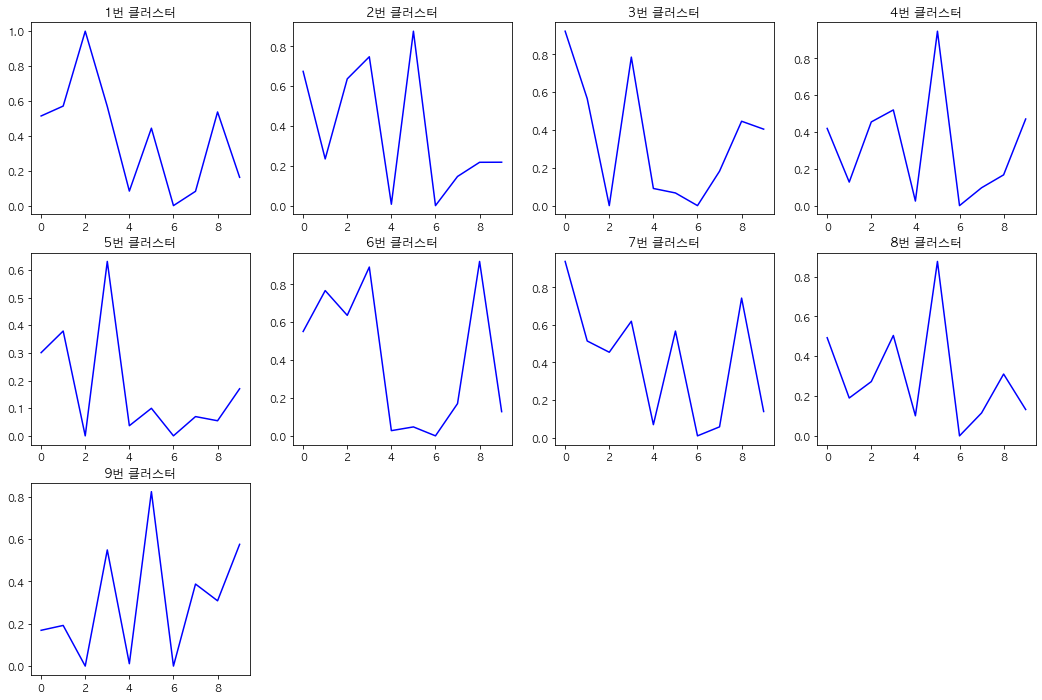

In [96]:
init_K = np.array([])
datas_count = len(merge_features)

while len(init_K) < K:
    _K = ran.randrange(0, datas_count)

    if (_K not in init_K):
        init_K = np.append(init_K, _K)

K_features = merge_features.loc[init_K].values[:,1:]

plt.figure(figsize=(18,12))
for idx,_K_features in enumerate(K_features):
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(_K_features, color='b')
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

# Cluster Label 부여

In [116]:
features = merge_features.values[:, 1:]
euc_check = euc(features, K_pattern)
labels = np.array([])

for _euc_check in euc_check:
    labels = np.append(labels,_euc_check.argmin())
    
label_df = pd.DataFrame()
label_df['id'] = merge_features['id']
label_df['label'] = labels.astype("int")
label_df.reset_index(inplace=True)
label_df.drop("index", inplace=True, axis=1)

label_df.head()

,id,label
0,2y4hHM6c48Qzk0bqh33XfB,3
1,1OQ3PoRZRtE7RH0NIh3p1O,2
2,1cayXr914ctuYeJkv3CPUR,3
3,1e5qALs3pDrv203jX0XWAC,3
4,5AkyvofVWUqds8x1HHgDU9,7


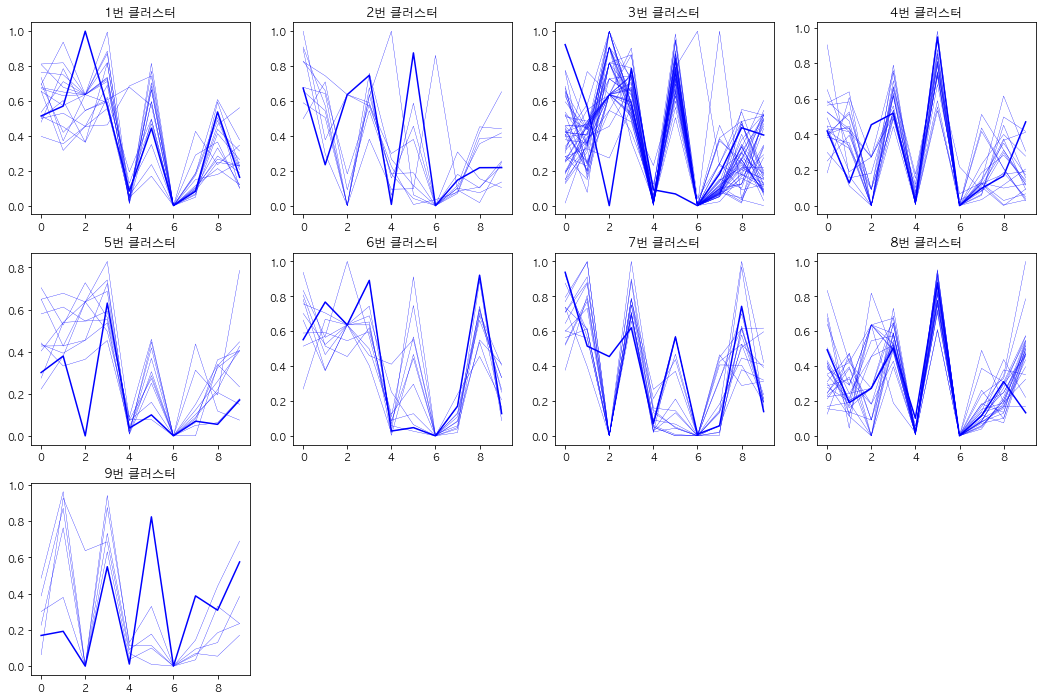

In [128]:
plt.figure(figsize=(18,12))
for idx,_K_features in enumerate(K_features):
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].T.values[1:]
    
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(_K_features, color='b')
    ax.plot(in_features, color='b', linewidth=0.3)
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()

# 중심값 이동

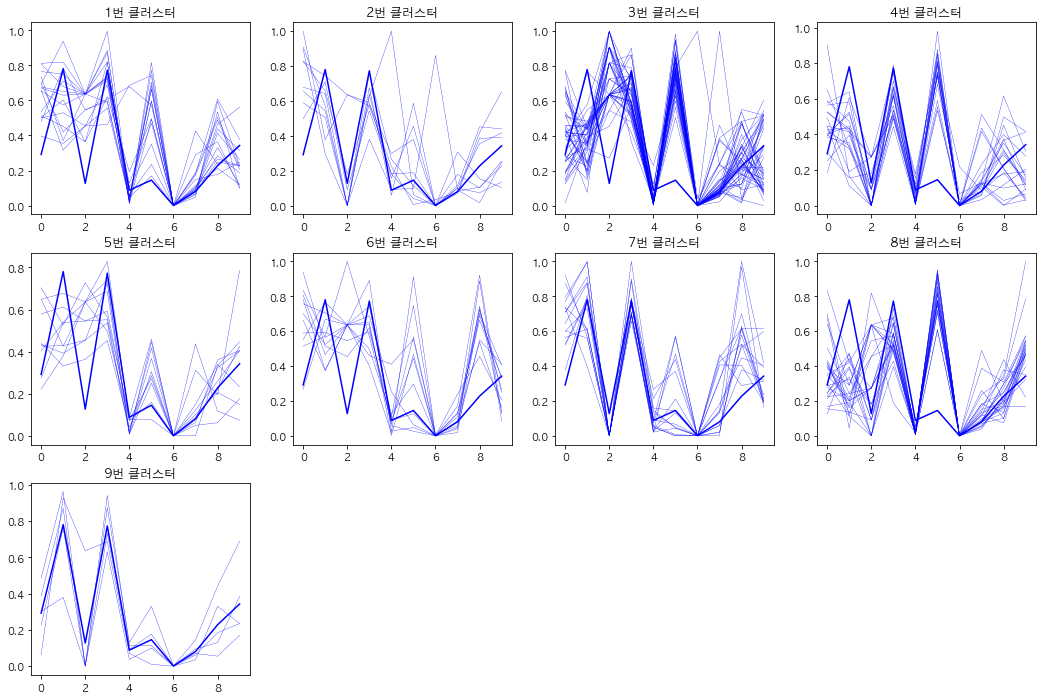

In [137]:
plt.figure(figsize=(18,12))
for idx,_ in enumerate(K_features):
    ids = label_df[label_df['label'] == idx].index
    in_features = merge_features.iloc[ids].values[:,1:]
    
    K_features[idx] = in_features.mean(axis=0)
    
    in_features = merge_features.iloc[ids].T.values[1:]
    
    ax = plt.subplot(plot_r, plot_c, idx + 1)
    ax.plot(_K_features, color='b')
    ax.plot(in_features, color='b', linewidth=0.3)
    ax.set_title("{}번 클러스터".format(idx + 1))
    
plt.show()